In [12]:
import numpy as np
from sympy import symbols
from contextlib import redirect_stdout
import subprocess
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from pathlib import Path
from mpmath import mp

In [13]:
def flatten(xss):
    return [x for xs in xss for x in xs]
mp.prec = 300
print(mp)

Mpmath settings:
  mp.prec = 300               [default: 53]
  mp.dps = 89                 [default: 15]
  mp.trap_complex = False     [default: False]


In [14]:
K = 16
d = 8
a = mp.zeros(1, d + 1)
# a[2] = mp.mpf('1')
# a[0], a[2], a[4] = mp.mpf('1.25'), mp.mpf('-1'), mp.mpf('0.2')
# a[2], a[4], a[8] = mp.mpf('0.5'), mp.mpf('-1'), mp.mpf('0.125')

In [15]:
def genF(energy, shift, E):
    Fmats = [mp.zeros(K) for _ in range(d)] + [mp.eye(K)]
    for i in range(K):
        for j in range(K):
            term = vars[i + j + shift].subs([(E, energy)])
            for k in range(d):
                Fmats[k][i, j] = term.coeff(vars[k])
                if k == 0:
                    Fmats[k][i, j] *= -1
            
    return Fmats

def create_input(energy, E, shift, file):
    with redirect_stdout(file):
        print(f'*Energy: {energy}')
        print(d) # mDIM
        print(1) # nBLOCK
        print(K) # bLOCKsTRUCT
        c = np.zeros(d)
        c[-1] = 1
        print(*c)
        Fmats = genF(energy, shift, E)
        for Fmat in Fmats:
            # print(*Fmat.reshape(-1))
            print(*flatten(Fmat.tolist()))

def solve(shift, E):
    num = 500
    Es = mp.linspace('0', '10', num)
    ts = mp.zeros(1, num)
    # ini_file = Path('aho.ini')
    # if ini_file.exists():
    #     ini_file.unlink()
    with open('status.log','w') as logfile:
        for i in range(num):
            with open('aho.dat','w') as f:
                create_input(Es[i], E, shift, f)
            args = ['sdpa_gmp','aho.dat','aho.result']
            # if ini_file.exists():
            #     args.append(ini_file.name)
            subprocess.run(args, stdout=subprocess.DEVNULL)
            with open('aho.result','r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.startswith('phase.value'):
                        status = line.split(' ')[2]
                        if status != 'pdOPT':
                            logfile.write(status + f' Energy: {Es[i]}' + '\n')
                    if line.startswith('objValPrimal'):
                        # t = float(line.split(' ')[2])
                        t = mp.mpf(line.split(' ')[2])
                        ts[i] = mp.log(mp.fabs(t))
                        break
                # if i == 0:
                #     p1 = lines.index('xVec = \n') + 1
                #     p2 = lines.index('xMat = \n') + 2
                #     p3 = lines.index('yMat = \n') + 2
                #     p4 = len(lines) - 4
                #     xVec = lines[p1][:-1]
                #     xMat = ''.join([lines[i][:-1] for i in range(p2, p3 - 3)])
                #     yMat = ''.join([lines[i][:-1] for i in range(p3, p4)])
                #     with open('aho.ini', 'w') as inif:
                #         with redirect_stdout(inif):
                #             print(xVec)
                #             print(xMat)
                #             print(yMat)
    np.savez(f'./data/ho_K_{K}_shift_{shift}',Es=Es,ts=ts)

In [23]:
vars = [symbols(f'x_{i}') for i in range(d)]
# note that x_0 = 1
E = symbols('E')
m = 0
lim = 5 * K
while d + m <= lim:
    t = (mp.mpf(4 * (m+1)) / (2 * a[d] * (d + 2 * m + 2))) * E * vars[m]
    if m >= 2:
        t = t + (mp.mpf(m * (m * m - 1)) / (2 * a[d] * (d + 2 * m + 2))) * vars[m - 2]
    for n in range(0, d):
        t = t - (mp.mpf(2 * (n + 2 * m + 2) * a[n]) / (2 * a[d] * (d + 2 * m + 2))) * vars[n + m]
    # t = t / (2 * a[d] * (d + 2 * m + 2))
    vars.append(t.simplify())
    m += 1

In [17]:
shifts = [0]
for shift in shifts:
    solve(shift, E)

[mpf('1.0020040080160320641282565130260521042084168336673346693386773547094188376753507014028056106')
 mpf('3.0060120240480961923847695390781563126252505010020040080160320641282565130260521042084168328')
 mpf('4.9498997995991983967935871743486973947895791583166332665330661322645290581162324649298597162')
 mpf('5.1302605210420841683366733466933867735470941883767535070140280561122244488977955911823647277')
 mpf('6.5731462925851703406813627254509018036072144288577154308617234468937875751503006012024048082')
 mpf('7.8957915831663326653306613226452905811623246492985971943887775551102204408817635270541082131')]


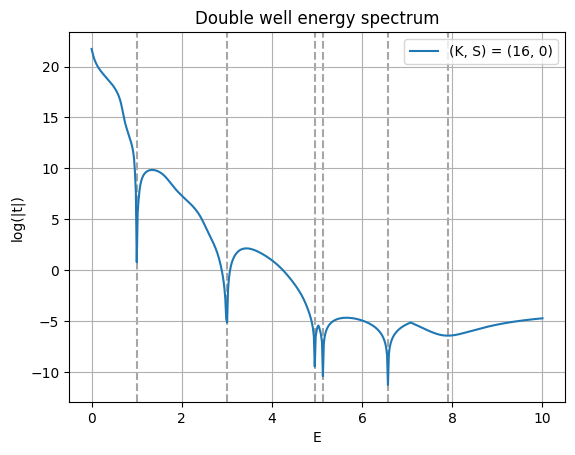

In [18]:
shifts = [0]
fig, ax = plt.subplots()
# ax.set_title('log(|t|) vs E with varying shifts')
ax.set_title('Double well energy spectrum')
ax.set_xlabel('E')
ax.set_ylabel('log(|t|)')
for shift in shifts:
    data = np.load(f'./data/ho_K_{K}_shift_{shift}.npz',allow_pickle=True)
    dips = data['Es'][find_peaks(-data['ts'],prominence=1)[0]]
    print(dips)
    for dip in dips:
        plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
    ax.plot(data['Es'], data['ts'], label=f'(K, S) = {(K, shift)}')
    # ax.plot(data['Es'], data['ts'], label=f'K = {K}')
ax.legend()
ax.grid()
# ax.set_xlim(1.8,2.1)
plt.show()

In [19]:
# def create_shift_plot(shifts):
#     fig, ax = plt.subplots()
#     # ax.set_title('log(|t|) vs E with varying shifts')
#     ax.set_title('Anharmonic oscillator energy spectrum')
#     ax.set_xlabel('E')
#     ax.set_ylabel('log(|t|)')
#     for shift in shifts:
#         data = np.load(f'./data/aho_K_{K}_shift_{shift}.npz')
#         dips = data['Es'][find_peaks(-data['ts'],prominence=1)[0]]
#         print(dips)
#         for dip in dips:
#             plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
#         # ax.plot(data['Es'], data['ts'], label=f'(K, S) = {(K, shift)}')
#         ax.plot(data['Es'], data['ts'], label=f'K = {K}')
#     ax.legend()
#     ax.grid()
#     return fig, ax

In [20]:
# shifts = [0]
# fig, ax = create_shift_plot(shifts)
# plt.show()

In [21]:
# Ks = [16, 18]
# fig, ax = plt.subplots()
# ax.set_title('Anharmonic oscillator energy spectrum')
# ax.set_xlabel('E')
# ax.set_ylabel('log(|t|)')
# for K in Ks:
#     data = np.load(f'./data/aho_K_{K}_shift_{0}.npz')
#     if K == max(Ks):
#         dips = data['Es'][find_peaks(-data['ts'],prominence=1)[0]]
#         print(dips)
#         for dip in dips:
#             plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
#     ax.plot(data['Es'], data['ts'], label=f'K = {K}')
# ax.legend()
# ax.grid()
# plt.show()

In [22]:
# plt.plot(Es, ts, label=f'K = {K}')
# dips = Es[find_peaks(-ts,prominence=0.1)[0]]
# print(dips)
# for dip in dips:
#     plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
# plt.title('log(|t|) vs E')
# plt.xlabel('E')
# plt.ylabel('log(|t|)')
# plt.legend()
# plt.grid()
# plt.show()